In [1]:
import sys
from utils.basic_utils import *
from utils.pricing import *
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.precision', 3)
cmap = 'tab20'
fs, lw, alp, loc, margin = (12,5), 5, 0.5, 'center left', (1, 0.5)
sl = 3 # to slice large lists in top / bottom chunks
# pd.describe_option()

Loading utils/config.json


### General functions

In [2]:
# utility functions
freq_dist = lambda df, col, tail: df[col].tail(tail).value_counts(bins=12, normalize=True).sort_index()
shorten_name = lambda x: "".join([str.upper(z[:3]) for z in x])
roll_vol = lambda df, rw: (df.rolling(rw).std() * pow(252, 1/2))

# helper methods
def build_px_struct(data_dict, freq):
    dt = date if freq == '1d' else datetime
    dates = [dt.fromtimestamp(x) for x in data_dict['timestamp']]
    hist_pricing = data_dict['indicators']['quote'][0]
    H = hist_pricing['high']
    L = hist_pricing['low']
    O = hist_pricing['open']
    C = hist_pricing['close']
    V = hist_pricing['volume']
    price_dict = {'high': H,'low': L,'open': O,'close' : C, 'volume': V}
    df = pd.DataFrame(price_dict, index=dates)    
    return df

def get_rt_pricing(symbol, freq='1d', prange='10d', cols=None):
    data_dict = get_pricing(symbol, freq, prange)
    df = build_px_struct(data_dict, freq)
    cols = df.columns if cols is None else cols
    return df[cols].dropna()

def get_symbol_pricing(symbol, freq, cols=None):
    path = config['pricing_path'].format(freq)
    data_dict = json_load(path + json_ext.format(symbol))
    df = build_px_struct(data_dict, freq)
    cols = df.columns if cols is None else cols
    return df[cols].dropna()

def get_mults_pricing(symbols, freq, col='close'):
    group_pricing = pd.DataFrame()
    for n, t in enumerate(symbols):
        print("Getting pricing for {0}".format(t))
        sec_hp = get_symbol_pricing(t, freq,[col])
        sec_hp.rename(columns={col: t}, inplace=True)
        if n == 0: group_pricing = pd.DataFrame(sec_hp)
        else: group_pricing[t] = sec_hp
    return group_pricing

def apply_std_boundaries(df, col='close', window=30, stds=2):
    sma = df[col].rolling(window).mean()
    smastd = df[col].rolling(window).std()
    smaub = sma + smastd*stds
    smalb = sma - smastd*stds
    df['sma' + str(window)] = sma
    df['sma' + str(window) + 'ub'] = smaub
    df['sma' + str(window) + 'lb'] = smalb
    df['sma' + str(window) + 'bw'] = smastd*stds / sma
    return df

def get_ind_index(closepx, freq='1d', tail=60, name='^IND'):
    closepx = closepx.tail(tail)
    memb_count = len(symbols)
    eq_wgt = 1 / memb_count
    closepx.set_index(pd.DatetimeIndex(closepx.index), inplace=True)
    comp_indexed = (closepx.pct_change() + 1).cumprod()
    comp_indexed.iloc[0] = 1
    # comp_indexed.pct_change(), closepx.pct_change() # CHECK, should be the same
    comp_indexed[name] = (comp_indexed * eq_wgt).sum(axis=1)
    return comp_indexed

def to_index_form(df, name):
    dt_index = pd.DatetimeIndex(df.index)
    idx = pd.DataFrame((df.pct_change() + 1).cumprod().values, 
        index=dt_index, columns=[name])
    idx.iloc[0] = 1
    return idx

def beta(df):
    # first column is the market
    X = df.values[:, [0]]
    # prepend a column of ones for the intercept
    X = np.concatenate([np.ones_like(X), X], axis=1)
    # matrix algebra
    b = np.linalg.pinv(X.T.dot(X)).dot(X.T).dot(df.values[:, 1:])
    return pd.Series(b[1], df.columns[1:], name='Beta')

def get_statspc_dates(df, treshold):
    mask = df.abs() / df.std() > treshold
    return df[mask][(df[mask].sum(axis=1) != 0).values]

def eq_wgt_attribution(comp_idx, index_col, resample_period):
    rp_delta = comp_idx.sub(comp_idx[index_col], axis='rows').iloc[:,:-1]
    resampled = (rp_delta/len(rp_delta.columns)).resample(resample_period, level=0).sum()
    return resampled[resampled.iloc[-1].sort_values(ascending=False).index]

def rank_roll_perf(df, roll_window):
    ind_ranked = df.round(2).rank(axis=1)
    rolled_ranked = ind_ranked.rolling(roll_window).mean()
    show = rolled_ranked.iloc[-1].sort_values().index.tolist()
    return rolled_ranked[show]

def get_left_right(alist, sl):
    # mods large list into left / right chunks
    be = len(alist) // sl
    left, right = be + 1 if be * sl < len(alist) else be, be
    return left, right



In [2]:
# contextual information
symbol = 'VCYT'
market_etf = 'SPY'
freq, tail = '1d', 20 * 6
window, stds = 20, 1.75

dates = read_dates('quote') 
tgt_date = [dates[-1]] # last date saved in S3
# latest_quotes = load_csvs('quote_consol', tgt_date)
quotes = load_csvs('quote_consol', tgt_date)
profile = load_csvs('summary_detail', ['assetProfile'])
show = ['symbol','sector', 'industry']
industries = profile[show].sort_values(by='industry').industry.dropna().unique().tolist()
left, right = get_left_right(industries, sl)
sect_idx_ticker, ind_idx_ticker = '^SECT', '^IND'

Loading file quote/csv/2019-04-16
Loading file summary-categories/assetProfile


### Retrieve pricing

In [8]:
# TAKES LONG: all pricing loaded, should do only once
symbols_list = config['benchmarks'] + config['sectors'] + config['industries'] + config['companies'] + config['risk']
px_close = load_px_close('../tmp/', 'universe-px-ds', True).drop_duplicates().dropna(subset=['^GSPC'])
px_set = px_close[excl(symbols_list, ['LYFT'])]
px_close.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3775 entries, 2004-04-19 to 2019-04-16
Columns: 1307 entries, 0700.HK to KRW=X
dtypes: float32(1307)
memory usage: 18.9+ MB


### VIX

(11.985000000000001, 14.015]    0.808
(14.015, 16.02]                 0.617
(16.02, 18.025]                 0.492
(18.025, 20.03]                 0.300
(20.03, 22.035]                 0.167
(22.035, 24.04]                 0.125
(24.04, 26.045]                 0.050
(26.045, 28.05]                 0.050
(28.05, 30.055]                 0.025
(30.055, 32.06]                 0.008
(32.06, 34.065]                 0.008
(34.065, 36.07]                 0.000
Name: close, dtype: float64

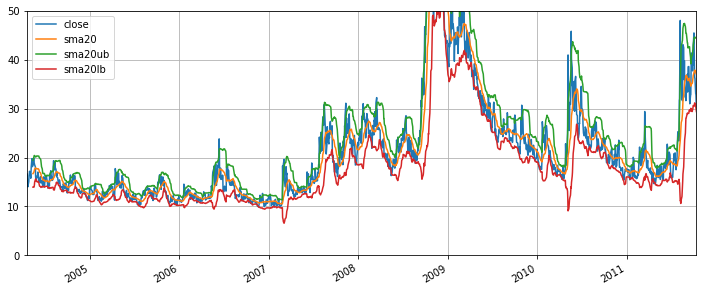

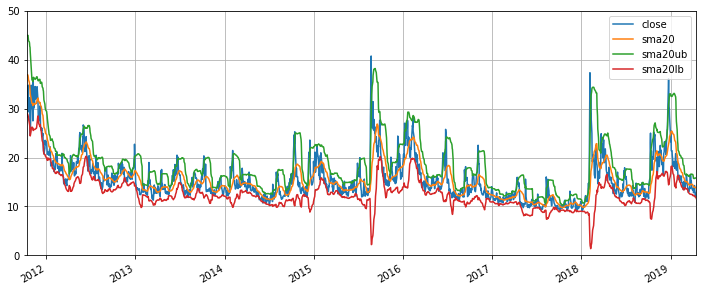

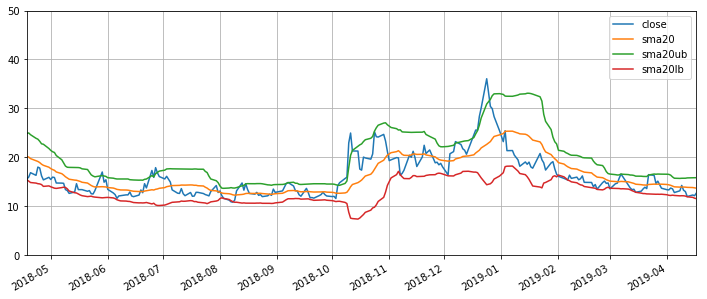

In [189]:
# Apply BB to VIX
symbol = '^VIX'
# sec_pricing = get_symbol_pricing(symbol, freq, ['open', 'low', 'high', 'close'])
secpx = get_symbol_pricing(symbol, freq)
show = ['close']
df = apply_std_boundaries(secpx, show, 20, 1.75)
smacols = [x for x in df.columns if 'sma' in x]
show = ['close'] + smacols

# historical frequency
freq_col = 'close' # show[-1]
left, right = get_left_right(df, 2)
df[show[:-1]].iloc[:left].plot(figsize=fs, ylim=[0, 50], grid=True)
df[show[:-1]].iloc[-right:].plot(figsize=fs, ylim=[0, 50], grid=True)
df[show[:-1]].iloc[-252:].plot(figsize=fs, ylim=[0, 50], grid=True)
fd = freq_dist(df, freq_col, tail)
(1 - fd.cumsum()).round(3)
# pd.DataFrame(fd).plot.barh(label='index')

In [11]:
# Historical analysis when portfolio insurance is cheap
# When does vol crosses [low] bound at [x] std
show = ['close','sma20ub']
dates = df[df.close < df.sma20lb].index.tolist()
abovesma = pd.DataFrame([{'year':x.year, 'month':x.month, 'day':x.day} for x in dates])
abovesma.pivot_table(index='year', columns='month', aggfunc='count').replace(np.nan, '')

day                                 
month  1  2  3  4  5  6  7  8  9  10 11 12
year                                      
2004                1  1  1     1  1  2  8
2005       3     3     1  1     3     4  1
2006       1  1              4  1  3  5   
2007    1                       4        4
2008       2     2  4        1        1  2
2009             3  4  3                  
2010    2  1     2              2  3      
2011    1        3        1        1  1  2
2012    2  1  3        3     1        2   
2013                         2        2   
2014                4  2              2   
2015             1     1           3      
2016          3     2        1            
2017                                  1   
2018             1  3        3        1   
2019       4  1

In [12]:
# Last few dates the VIX is below trend
abovesma.tail(5)

,day,month,year
140,1,2,2019
141,4,2,2019
142,5,2,2019
143,6,2,2019
144,1,3,2019


### Sector overview

In [13]:
# Pull sector ETFs for relative performance
symbols = config["sectors"]
closepx = px_set[symbols]
# openpx = get_mults_pricing(symbols, freq, 'open')
# ((closepx - openpx) / openpx * 100).std().sort_values().plot.barh()

comp_idx = get_ind_index(px_set[symbols], freq, tail, ind_idx_ticker)
SPY = get_symbol_pricing('SPY', freq, 'close').tail(tail)
comp_idx.drop(ind_idx_ticker, axis=1, inplace=True)
comp_idx['SPY'] = to_index_form(SPY, 'SPY')

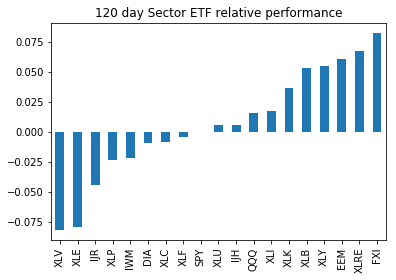

In [15]:
# Sector relative performance
cumulative = comp_idx.iloc[-1]
last_delta = cumulative - cumulative['SPY']
ctitle = '{} day Sector ETF relative performance'.format(tail)
last_delta.sort_values(ascending=True).plot(kind='bar', label='index', title=ctitle)

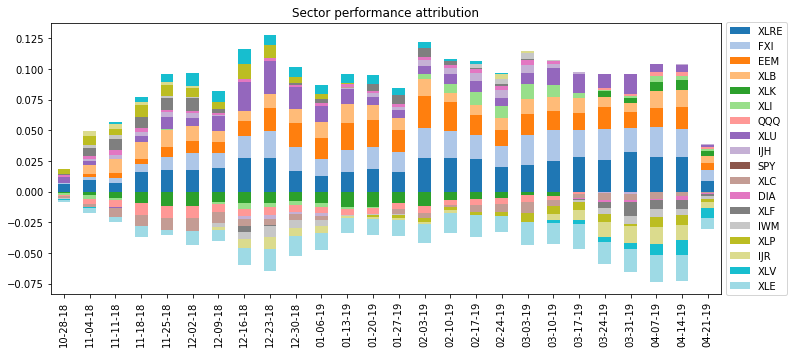

In [21]:
# Sector performance attribution
resampled = eq_wgt_attribution(comp_idx, 'SPY', 'W')
ctitle = 'Sector performance attribution'
ax = resampled.plot(kind='bar', stacked=True, figsize=(12,5), colormap=cmap, title=ctitle)
ax.set_xticklabels(resampled.index.strftime('%m-%d-%y'));
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

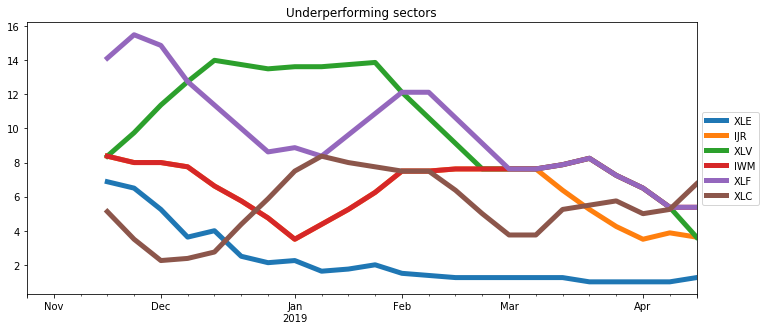

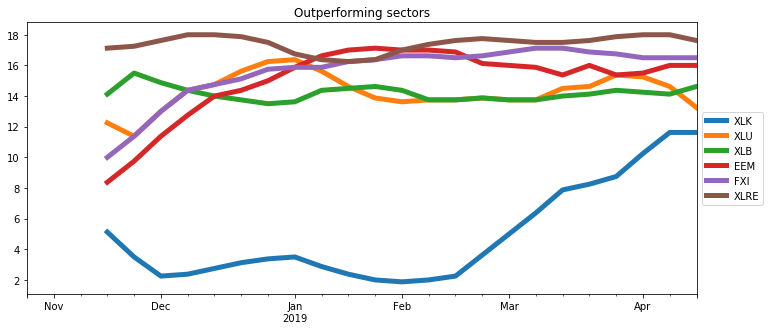

In [23]:
# Sector performance rankings
roll_window = 4
rank_rolled = rank_roll_perf(resampled, roll_window)
left, right = get_left_right(rank_rolled.columns, sl)

ctitle = 'Underperforming sectors'
rank_rolled.iloc[:,:left].plot(figsize=fs, linewidth=lw, title=ctitle)\
    .legend(loc=loc, bbox_to_anchor=margin)
ctitle = 'Outperforming sectors'
rank_rolled.iloc[:,-right:].plot(figsize=fs, linewidth=lw, title=ctitle)\
    .legend(loc=loc, bbox_to_anchor=margin);

### Industry overview

In [28]:
# Calculate industry indices
ind_indices = pd.DataFrame()
for n, ind in enumerate(industries):
    ind_id = shorten_name(ind)
    symbols = profile[profile.industry == ind].symbol.tolist()
    comp_idx = get_ind_index(px_set[symbols], '1d', tail, ind_id)
    ind_idx = comp_idx.iloc[:, -1:]
    if n == 0: ind_indices = pd.DataFrame(ind_idx)
    else: ind_indices[ind_id] = ind_idx

In [102]:
q = int(ind_indices.shape[1]*.1)
focus_ind = list(ind_indices.iloc[-1, :].sort_values().iloc[:q].index) + list(ind_indices.iloc[-1, :].sort_values().iloc[-q:].index)

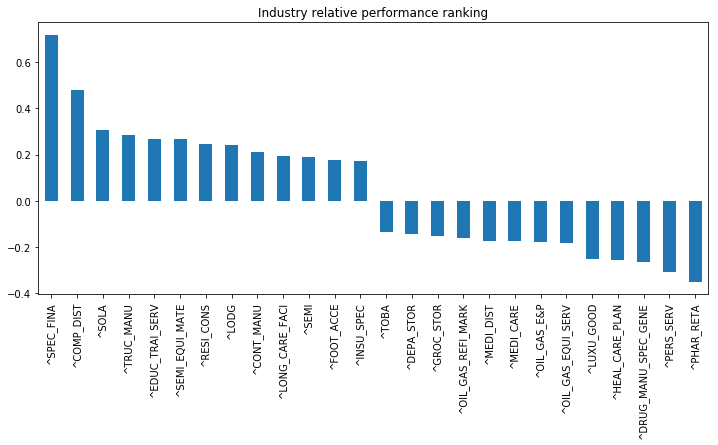

In [103]:
# Industry performance relative ranking
SPY = get_symbol_pricing('SPY', freq, 'close').tail(tail)
ind_indices['SPY'] = to_index_form(SPY, 'SPY')
cumulative = ind_indices.iloc[-1]
last_delta = cumulative - cumulative['SPY']
# last_delta = cumulative
ctitle = 'Industry relative performance ranking'
last_delta[focus_ind].sort_values(ascending=False).plot(
    kind='bar', label='index', figsize=(12,5), title=ctitle);

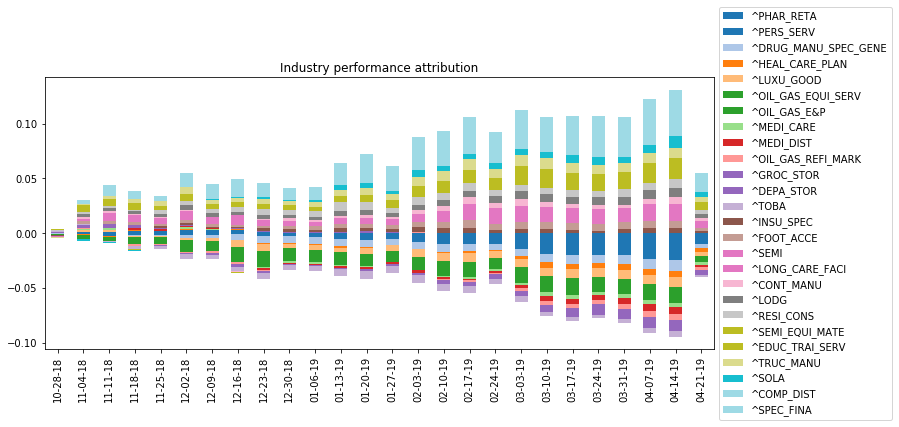

In [105]:
# Industry performance attribution
resampled = eq_wgt_attribution(ind_indices, 'SPY', 'W')
ctitle = 'Industry performance attribution'
ax = resampled[focus_ind].plot(kind='bar', stacked=True, 
                    figsize=(12,5), colormap=cmap, title=ctitle)
ax.set_xticklabels(resampled.index.strftime('%m-%d-%y'));
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

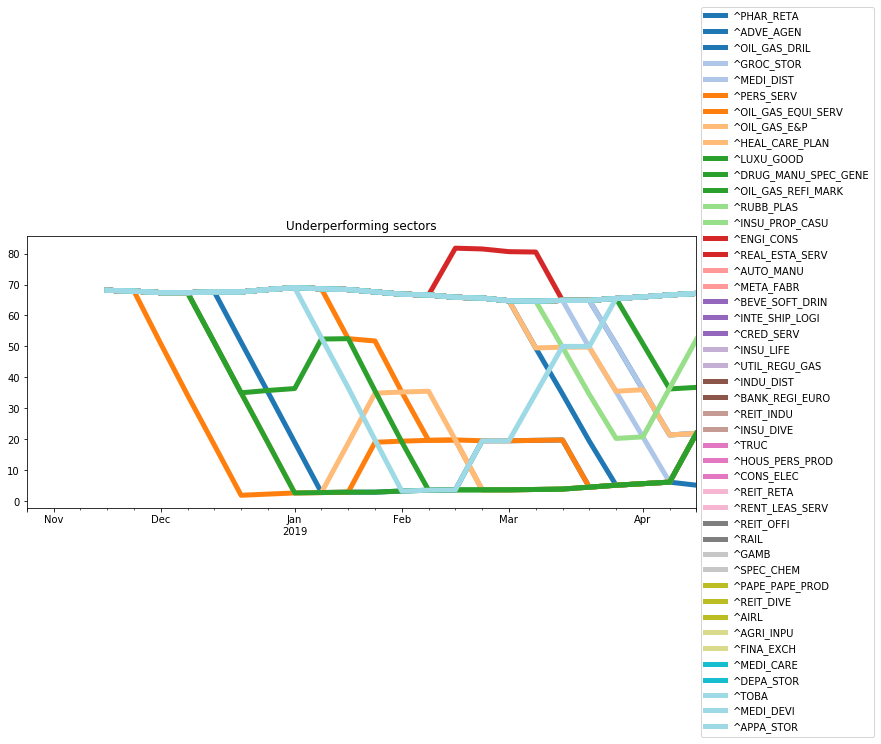

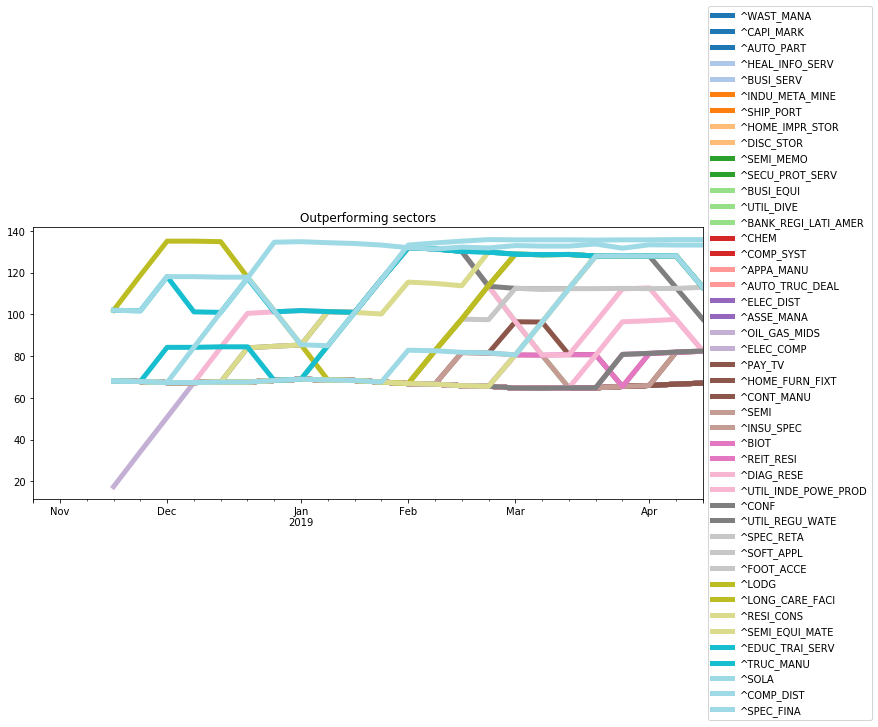

In [106]:
# Industry performance rankings
resampled = eq_wgt_attribution(ind_indices, 'SPY', 'W')
rank_rolled = rank_roll_perf(resampled, 4)
left, right = get_left_right(rank_rolled.columns, sl)

ctitle = 'Underperforming sectors'
rank_rolled.iloc[:,:left].plot(
    figsize=fs, linewidth=lw, colormap=cmap, title=ctitle)\
        .legend(loc=loc, bbox_to_anchor=margin);
ctitle = 'Outperforming sectors'
rank_rolled.iloc[:,-right:].plot(
    figsize=fs, linewidth=lw, colormap=cmap, title=ctitle)\
        .legend(loc=loc, bbox_to_anchor=margin);

### Industry deep dive

In [112]:
tgt_industry

'Conglomerates'

In [117]:
tgt_industry = industries[1]
symbols = profile[profile.industry == tgt_industry].symbol.tolist()
ind_id = shorten_name(tgt_industry)
[(shorten_name(ind[1]), ind) for ind in enumerate(industries)]

[('^ADVE_AGEN', (0, 'Advertising Agencies')),
 ('^AERO_DEFE', (1, 'Aerospace & Defense')),
 ('^AGRI_INPU', (2, 'Agricultural Inputs')),
 ('^AIRL', (3, 'Airlines')),
 ('^APPA_MANU', (4, 'Apparel Manufacturing')),
 ('^APPA_STOR', (5, 'Apparel Stores')),
 ('^ASSE_MANA', (6, 'Asset Management')),
 ('^AUTO_TRUC_DEAL', (7, 'Auto & Truck Dealerships')),
 ('^AUTO_MANU', (8, 'Auto Manufacturers')),
 ('^AUTO_PART', (9, 'Auto Parts')),
 ('^BANK_GLOB', (10, 'Banks - Global')),
 ('^BANK_REGI_ASIA', (11, 'Banks - Regional - Asia')),
 ('^BANK_REGI_EURO', (12, 'Banks - Regional - Europe')),
 ('^BANK_REGI_LATI_AMER', (13, 'Banks - Regional - Latin America')),
 ('^BANK_REGI_US', (14, 'Banks - Regional - US')),
 ('^BEVE_BREW', (15, 'Beverages - Brewers')),
 ('^BEVE_SOFT_DRIN', (16, 'Beverages - Soft Drinks')),
 ('^BEVE_WINE_DIST', (17, 'Beverages - Wineries & Distilleries')),
 ('^BIOT', (18, 'Biotechnology')),
 ('^BROA_TV', (19, 'Broadcasting - TV')),
 ('^BUIL_MATE', (20, 'Building Materials')),
 ('^BUSI

Aerospace & Defense analysis for 120 days


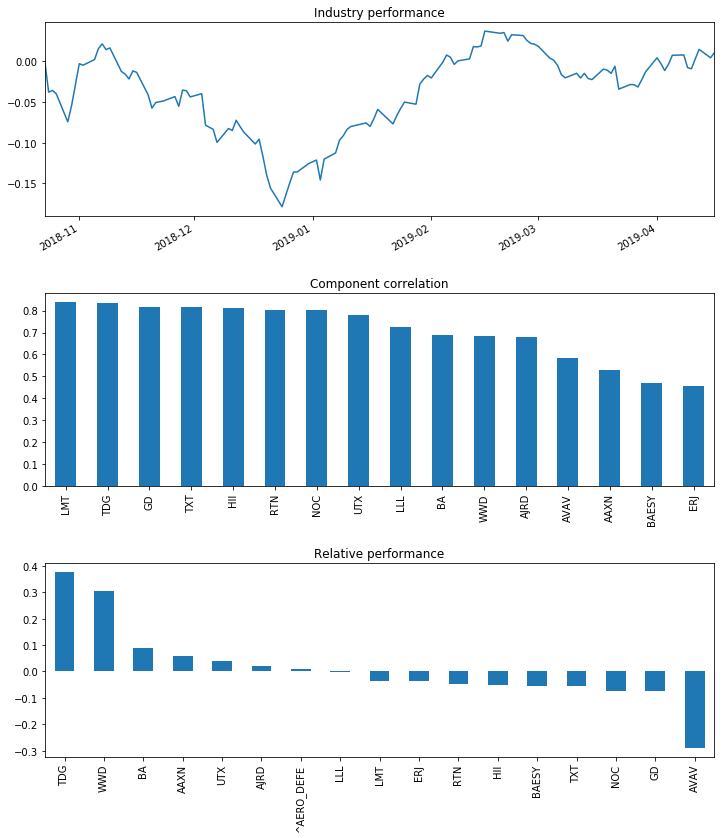

In [118]:
# Industry overview charts
comp_idx = get_ind_index(px_set[symbols], '1d', tail, ind_id)
fig, axs = plt.subplots(ncols=1, nrows=3, constrained_layout=False, figsize=(12,15))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

print('{} analysis for {} days'.format(tgt_industry, tail))
(comp_idx[ind_id] - 1).plot(
    ax=axs[0], title='Industry performance');

comp_idx.pct_change().corr()[ind_id].iloc[:-1].sort_values(ascending=False).plot(
    kind='bar', ax=axs[1], title='Component correlation');

(comp_idx.iloc[-1].sort_values(ascending=False) - 1).plot(
    kind='bar', ax=axs[2], title='Relative performance');

plt.show()

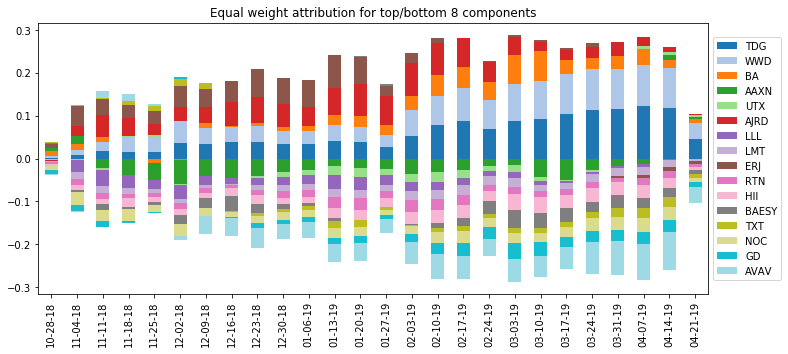

In [119]:
# Industry components performance attribution
resampled = eq_wgt_attribution(comp_idx, ind_id, 'W')
left, right = get_left_right(resampled.columns, 2)
show = resampled.columns[:(left)].tolist() + resampled.columns[-right:].tolist()
ctitle = 'Equal weight attribution for top/bottom {} components'.format(left, ind_id)
ax = resampled[show].plot(
    colormap=cmap, kind='bar', stacked=True, figsize=(12,5), title=ctitle)
ax.set_xticklabels(resampled.index.strftime('%m-%d-%y'));
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

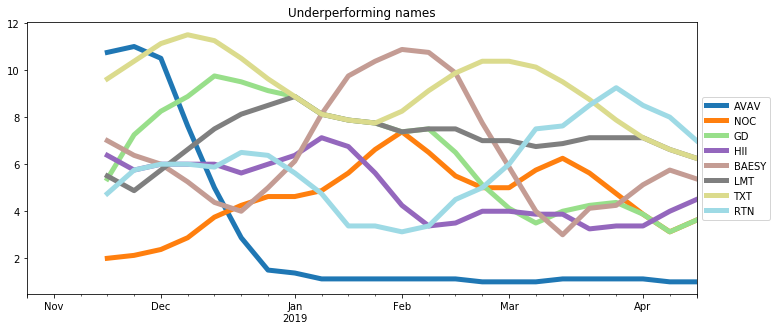

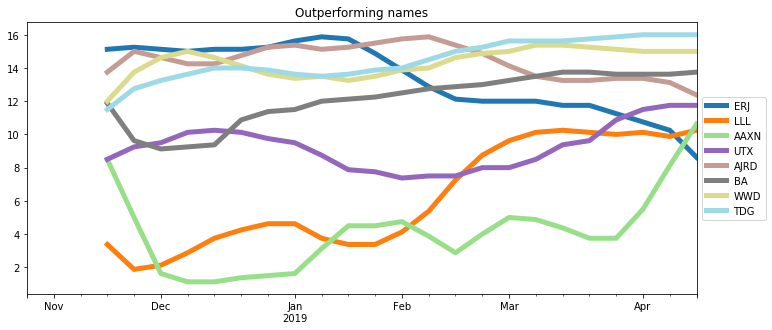

In [176]:
# Industry components performance ranking
rank_rolled = rank_roll_perf(resampled, 4)
ctitle = 'Underperforming names'
rank_rolled.iloc[:,:left].plot(
    figsize=fs, linewidth=lw, colormap=cmap, title=ctitle)\
        .legend(loc=loc, bbox_to_anchor=margin);
ctitle = 'Outperforming names'
rank_rolled.iloc[:,-right:].plot(
    figsize=fs, linewidth=lw, colormap=cmap, title=ctitle)\
        .legend(loc=loc, bbox_to_anchor=margin);

### Company relative to industry, sector and market performance
What's a statistically significant move?<br>
De-correlate vs. industry, sector, and market<br>
List key dates<br>
Create function to highlight relevant idiosincratic behaviour<br>

In [190]:
symbol = 'FB'
row = profile[profile.symbol == symbol]
sec_sector, sec_industry = row.iloc[0].sector, row.iloc[0].industry
sec_sector, sec_industry

('Technology', 'Internet Content & Information')

In [191]:
sec_index = to_index_form(
    get_symbol_pricing(symbol, freq, 'close').tail(tail),
    symbol)

symbols = profile[profile.industry == sec_industry].symbol.tolist()
industry_index = get_ind_index(
    px_set[symbols], '1d', tail, ind_idx_ticker)[[ind_idx_ticker]]

symbols = profile[profile.sector == sec_sector].symbol.tolist()
sector_index = get_ind_index(
    px_set[symbols], '1d', tail, sect_idx_ticker)[[sect_idx_ticker]]

market_index = to_index_form(
    get_symbol_pricing(market_etf, freq, 'close').tail(tail),
    market_etf)

index_df = pd.DataFrame()
index_df = index_df.append(sec_index)
index_df[ind_idx_ticker] = industry_index
index_df[sect_idx_ticker] = sector_index
index_df[market_etf] = market_index

In [192]:
index_df_pc = index_df.pct_change().iloc[1:]
print('{} days SPY beta'.format(len(index_df_pc)))
beta(index_df_pc[[market_etf,symbol,ind_idx_ticker,sect_idx_ticker]])

119 days SPY beta


FB       1.263
^IND     1.295
^SECT    1.290
Name: Beta, dtype: float64

30 days rolling volatility


,FB,^IND,^SECT,SPY
2019-04-11,0.243,0.232,0.181,0.105
2019-04-12,0.244,0.232,0.182,0.105
2019-04-15,0.229,0.238,0.178,0.104
2019-04-16,0.221,0.228,0.178,0.104
2019-04-17,0.220,0.224,0.172,0.102


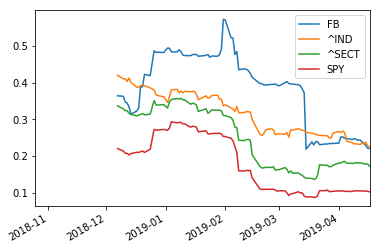

In [193]:
roll_window = 30
roll_vol_df = roll_vol(index_df_pc, roll_window)
print(f'{roll_window} days rolling volatility')
roll_vol_df.plot();
roll_vol_df.tail()

In [194]:
print(f'{len(index_df_pc)} days correlation matrix')
index_df_pc.corr()

119 days correlation matrix


,FB,^IND,^SECT,SPY
FB,1.000,0.598,0.623,0.617
^IND,0.598,1.000,0.856,0.738
^SECT,0.623,0.856,1.000,0.918
SPY,0.617,0.738,0.918,1.000


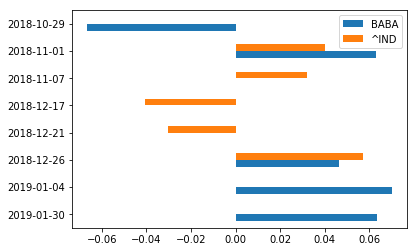

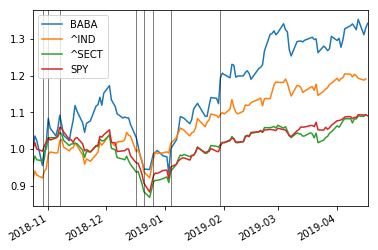

,BABA,^IND
2019-01-30,0.063,NaN
2019-01-04,0.070,NaN
2018-12-26,0.046,0.057
2018-12-21,NaN,-0.031
2018-12-17,NaN,-0.041
2018-11-07,NaN,0.032
2018-11-01,0.063,0.040
2018-10-29,-0.066,NaN


In [188]:
# show statistical significant moves for further key factors study
treshold = 2
statspc_df = get_statspc_dates(index_df_pc, treshold)
show = statspc_df.columns[:2]
filtered = statspc_df[statspc_df[show].sum(axis=1).abs() > 0][show].sort_index(ascending=False)
ax = filtered.plot(kind='barh')
ax.set_yticklabels(filtered.index.strftime('%Y-%m-%d'))
index_df.plot()
for d in filtered.index: plt.axvline(x=d, c='k', linewidth=0.5)

plt.show()
filtered

### Single security pricing, all fields

In [167]:
# Retrieves historical pricing
secpx = get_symbol_pricing(symbol, freq)
secpx.tail(5)

,high,low,open,close,volume
2019-04-11,56.500,52.900,55.97,53.05,416400
2019-04-12,54.060,52.410,53.87,53.06,464200
2019-04-15,53.685,51.520,53.17,52.99,498400
2019-04-16,55.070,52.845,53.50,53.67,452300
2019-04-17,54.900,51.250,53.88,54.68,478264


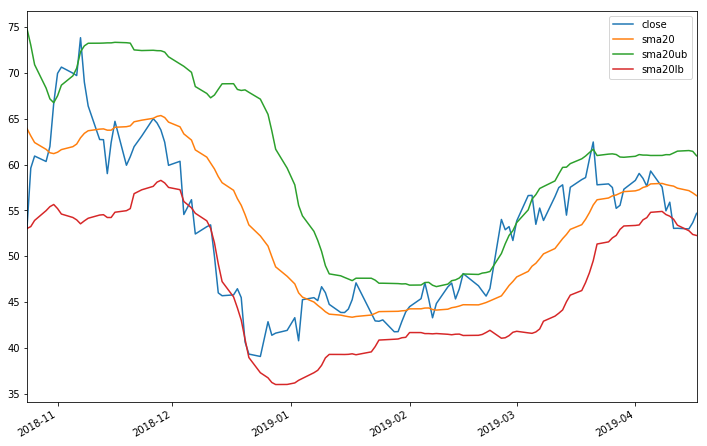

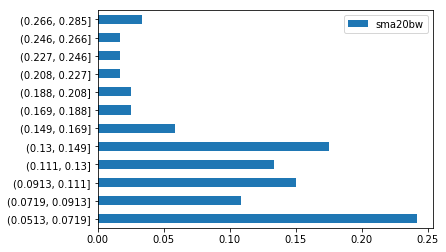

In [168]:
df = apply_std_boundaries(secpx, 'close', window, stds)
smacols = [x for x in df.columns if 'sma' in x]
show = ['close'] + smacols

df[show[:-1]].tail(tail).plot(secondary_y=freq_col, figsize=(12,8))

freq_col = 'sma' + str(window) + 'bw'
fd = freq_dist(df, freq_col, tail)
fd
pd.DataFrame(fd).plot.barh(label='index')

In [169]:
# Retrieves real-time pricing
# prange = '10y'
# secpx = get_rt_pricing(symbol, freq, prange)
# secpx.tail(5)

### Long exposure correlations

In [170]:
long_symbols = ['1810.HK', '9984.T', 'BABA', 'FB', 'GOOG', 'XOP']
nbr_pos = len(long_symbols)
# long_weights = [1/nbr_pos for x in long_symbols]
long_weights = [10.3, 3.7, 60.4, 22.3, 8.4, 3.18]
long_wv = np.array(long_weights) / 100

In [171]:
long_px = px_set[
    long_symbols + \
    config['benchmarks'] + \
    config['sectors']
    ].tail(tail)

# corr_mtrx = long_px.pct_change().corr()
corr_mtrx = long_px.pct_change().corr()
cov_mtrx = long_px.pct_change().cov() * 252

port_corr_mtrx = corr_mtrx.iloc[:nbr_pos, :nbr_pos]
port_cov_mtrx = cov_mtrx.iloc[:nbr_pos, :nbr_pos]
# tri_corr_mtrx = (port_corr_mtrx * np.tri(nbr_pos,nbr_pos, -1))
# cross_corr = np.dot(long_wv.T, np.dot(tri_corr_mtrx, long_wv))

cross_corr = np.dot(long_wv.T, np.dot(port_corr_mtrx, long_wv))
cross_vol = np.sqrt(np.dot(long_wv.T, np.dot(port_cov_mtrx, long_wv)))
ctitle = 'Portfolio {0} correlation {1} annualized volatility'.format(
    round(cross_corr,2), round(cross_vol,2))
print(ctitle)
port_corr_mtrx

Portfolio 0.72 correlation 0.31 annualized volatility


,1810.HK,9984.T,BABA,FB,GOOG,XOP
1810.HK,1.000,0.122,0.083,-0.055,0.121,0.031
9984.T,0.122,1.000,-0.088,-0.076,-0.052,-0.056
BABA,0.083,-0.088,1.000,0.572,0.683,0.604
FB,-0.055,-0.076,0.572,1.000,0.725,0.440
GOOG,0.121,-0.052,0.683,0.725,1.000,0.611
XOP,0.031,-0.056,0.604,0.440,0.611,1.000


In [172]:
top_corr_items = 3
corr_mtrx_bench = corr_mtrx.loc[long_symbols].T.iloc[nbr_pos:]
best_pairs = [(x, corr_mtrx_bench[corr_mtrx_bench[x] < 1][x].sort_values(ascending=False).index.tolist()[:top_corr_items]) for x in long_symbols]
best_pairs, corr_mtrx_bench

([('1810.HK', ['^HSI', '^GDAXI', 'FXI']),
  ('9984.T', ['^N225', '^HSI', '^FTSE']),
  ('BABA', ['FXI', 'EEM', '^IXIC']),
  ('FB', ['XLC', 'QQQ', '^IXIC']),
  ('GOOG', ['QQQ', 'XLC', '^IXIC']),
  ('XOP', ['XLE', 'IJH', 'SPY'])],
              1810.HK  9984.T   BABA     FB   GOOG    XOP
 ^DJI       8.149e-02  -0.065  0.657  0.549  0.764  0.747
 ^IXIC      9.102e-02  -0.096  0.754  0.700  0.881  0.733
 ^GSPC      9.529e-02  -0.067  0.697  0.629  0.820  0.770
 ^RUT       8.806e-02  -0.097  0.683  0.566  0.744  0.764
 ^STOXX50E  1.485e-01   0.076  0.316  0.182  0.257  0.378
 ^FTSE      2.227e-01   0.089  0.317  0.172  0.252  0.446
 ^GDAXI     2.590e-01  -0.014  0.400  0.208  0.340  0.439
 ^N225      2.094e-01   0.551  0.028 -0.045  0.025  0.093
 ^HSI       4.763e-01   0.271  0.354  0.060  0.194  0.261
 ^AXJO     -3.222e-02   0.007  0.217  0.280  0.294  0.392
 SPY        8.936e-02  -0.061  0.694  0.637  0.819  0.773
 QQQ        8.370e-02  -0.095  0.744  0.720  0.894  0.712
 DIA        8.149e

In [173]:
cols = []; [cols.extend(y) for x, y in best_pairs]
cols = list(set(cols))
port_exp = pd.DataFrame([], index=long_symbols, columns=cols)
# port_exp.loc['FB', ['XLU','FXI']] = [1, 2]
for x, y in best_pairs: port_exp.loc[x, y] = corr_mtrx_bench.T.loc[x, y]
port_exp.replace(np.nan, '')

,^GDAXI,^FTSE,^IXIC,XLE,FXI,^HSI,QQQ,SPY,^N225,IJH,XLC,EEM
1810.HK,0.259,,,,0.253,0.476,,,,,,
9984.T,,0.0885,,,,0.271,,,0.551,,,
BABA,,,0.754,,0.82,,,,,,,0.796
FB,,,0.7,,,,0.72,,,,0.844,
GOOG,,,0.881,,,,0.894,,,,0.889,
XOP,,,,0.943,,,,0.773,,0.776,,


In [174]:
# portfolio greatest exposure
pd.Series(
    np.dot(port_exp.replace(np.nan, 0).T, long_wv.T), index=cols)\
    .sort_values(ascending=False)

^IXIC     0.685
FXI       0.522
EEM       0.481
XLC       0.263
QQQ       0.236
^HSI      0.059
XLE       0.030
^GDAXI    0.027
IJH       0.025
SPY       0.025
^N225     0.020
^FTSE     0.003
dtype: float64

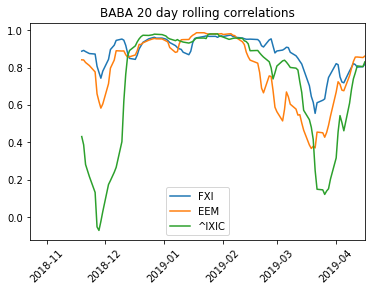

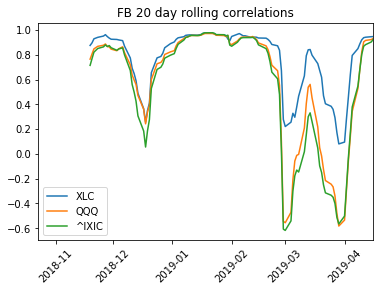

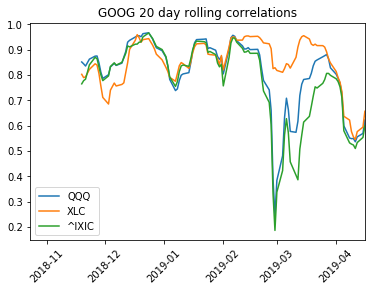

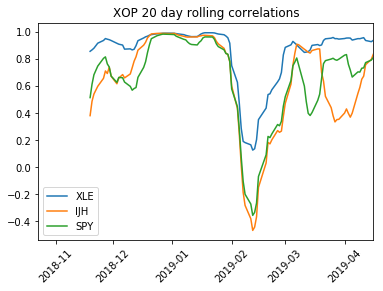

In [175]:
# Rolling correlation
roll_window = 20
missing_px = (long_px[long_symbols].count() < len(long_px[long_symbols])).tolist()
items = [best_pairs[x] for x in range(len(missing_px)) 
         if not missing_px[x]]
for x, y in items:
    title = '{} {} day rolling correlations'.format(x, roll_window)
    long_px[x]\
        .rolling(roll_window).corr(long_px[y])\
        .plot(title=title, rot=45)
# long_px.index.astype(date)

### Benchmark option pricing

In [140]:
options = load_csvs('option_consol', tgt_date)
cols_to_date = ['expiration', 'lastTradeDate', 'storeDate']
for c in cols_to_date: options[c] = options[c].apply(lambda x: datetime.fromtimestamp(x))
options.info()
# options.iloc[3]

Loading file option/csv/2019-04-16
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4226 entries, 0 to 4225
Data columns (total 18 columns):
ask                  4226 non-null float64
bid                  4226 non-null float64
change               4226 non-null float64
contractSize         4226 non-null object
contractSymbol       4226 non-null object
currency             4226 non-null object
expiration           4226 non-null datetime64[ns]
impliedVolatility    4226 non-null float64
inTheMoney           4226 non-null bool
lastPrice            4226 non-null float64
lastTradeDate        4226 non-null datetime64[ns]
openInterest         4226 non-null int64
percentChange        4226 non-null float64
strike               4226 non-null float64
volume               4226 non-null int64
underlyingSymbol     4226 non-null object
storeDate            4226 non-null datetime64[ns]
type                 4226 non-null object
dtypes: bool(1), datetime64[ns](3), float64(7), int64(2), object(5)
memory 

In [272]:
# find expirations with more than 90 days
def option_IV_atm(options, symbol, calDaysOut, minVolume, optnType, nbrStrikes):
    symbols = config['benchmarks'] + config['sectors']
    next_dt = np.datetime64(datetime.today() + pd.Timedelta(calDaysOut, unit='d'))
    uniq_expirations = options.expiration.sort_values().unique()
    tgt_expirations = uniq_expirations[uniq_expirations > next_dt]
    mask = (options.underlyingSymbol.isin(symbols)) &\
        (options.volume > minVolume) &\
        options.expiration.isin(tgt_expirations) &\
        (options.type == optnType)
    subset = options[mask]
    last_price = px_set[symbols].iloc[-1][symbol]
    contracts = subset[subset.underlyingSymbol == symbol]
#     atm_contract = (contracts.strike / last_price - 1).abs().idxmin()
    atm_contract = (contracts.strike / last_price - 1).abs().\
        sort_values().index[:nbrStrikes]
    return contracts.loc[atm_contract].sort_values(by='strike')

In [280]:
# shows implied volatility for all benchmarks
symbols = config['benchmarks'] + config['sectors']
b_IVs = pd.DataFrame()
for s in symbols:
#     print('Current price for {}: {}'.format(s, px_set[s].iloc[-1]))
    b_IVs = b_IVs.append(option_IV_atm(options, s, 90, 50, 'put', 1))
show = ['underlyingSymbol', 'expiration', 
        'strike', 'impliedVolatility', 
        'openInterest', 'volume','lastTradeDate']
# b_IVs[show].plot(kind='bar', x=show[0], y=show[1])
b_IVs[show].sort_values(by='expiration')

,underlyingSymbol,expiration,strike,impliedVolatility,openInterest,volume,lastTradeDate
9465,IJR,2019-05-16 17:00:00,77.0,0.170,40.0,86.0,2018-12-24 07:22:02
9247,FXI,2019-05-16 17:00:00,43.0,0.182,597.0,207.0,2019-02-05 12:53:04
11804,SPY,2019-06-20 17:00:00,271.0,0.150,1581.0,96.0,2019-02-12 08:00:24
14004,XLP,2019-06-20 17:00:00,53.0,0.142,371.0,200.0,2019-02-11 12:29:19
13658,XLI,2019-06-20 17:00:00,74.0,0.171,550.0,387.0,2019-02-04 12:55:57
13438,XLF,2019-06-20 17:00:00,25.0,0.185,32658.0,130.0,2019-02-12 08:27:08
12961,XLC,2019-06-20 17:00:00,35.0,0.313,72.0,100.0,2019-02-04 11:38:00
14585,XLY,2019-06-20 17:00:00,109.0,0.165,118.0,79.0,2019-02-12 07:56:45
9923,IWM,2019-06-20 17:00:00,151.0,0.168,800.0,263.0,2019-02-12 08:01:27
10700,QQQ,2019-06-20 17:00:00,168.0,0.183,8054.0,135.0,2019-02-12 08:06:26


In [281]:
# issue here is that rows could have diff. expirations
# shows mutiple implied volatility for one benchmark
symbol = 'XLK'
contract_list = option_IV_atm(options, symbol, 90, 50, 'put', 5)
contract_list[show].sort_values(by='expiration')

,underlyingSymbol,expiration,strike,impliedVolatility,openInterest,volume,lastTradeDate
13845,XLK,2019-06-20 17:00:00,72.0,0.164,995.0,876.0,2019-01-30 12:27:00
13882,XLK,2020-01-16 16:00:00,56.0,0.241,438.0,400.0,2019-01-28 07:09:30
13892,XLK,2020-01-16 16:00:00,66.0,0.196,245.0,282.0,2019-02-08 11:56:31
13918,XLK,2021-01-14 16:00:00,65.0,0.197,1455.0,350.0,2019-02-08 12:24:10
13922,XLK,2021-01-14 16:00:00,69.0,0.185,77.0,75.0,2018-11-08 11:39:21


In [ ]:
# PENDING: shows historical implied volatility for one benchmark
symbol = 'SPY'
b_IVs = pd.DataFrame()
for d in [dates[-20:]]:
    options = load_csvs('option_consol', d)
    cols_to_date = ['expiration', 'lastTradeDate', 'storeDate']
    for c in cols_to_date: 
        options[c] = options[c].apply(lambda x: datetime.fromtimestamp(x))
    option_IV_atm(options, symbol, 60, 50, 'put', 1)
b_IVs[show]

### Other functions

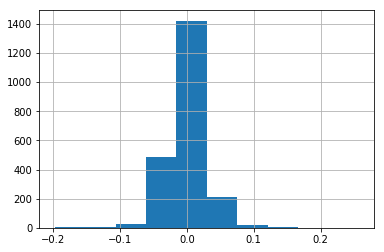

In [2046]:
df['hlSpread'] = (df['high'] - df['low']) / df['open']
df['coSpread'] = (df['close'] - df['open']) / df['open']
df['1mFwdRet'] = df['close'].shift(-20) / df['close'] - 1
df.coSpread.hist()
# df[df.coSpread < -0.075]

In [131]:
path = config['pricing_path'].format('1d')
data_dict = json_load(path + json_ext.format(symbol))
print(data_dict.keys())
data_dict['meta']
dates = [datetime.fromtimestamp(x) for x in data_dict['timestamp']]
indicators_quote_0 = data_dict['indicators']['quote'][0]
H = indicators_quote_0['high']
L = indicators_quote_0['low']
O = indicators_quote_0['open']
C = indicators_quote_0['close']
V = indicators_quote_0['volume']

dict_keys(['meta', 'timestamp', 'indicators'])


In [36]:
price_dict = {'high': H,'low': L,'open': O,'close' : C, 'volume': V}
df = pd.DataFrame(price_dict, index=dates)

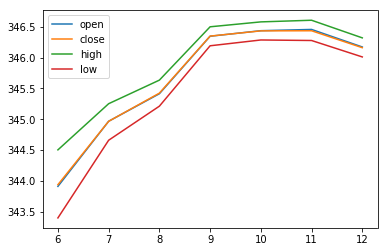

In [18]:
fields = ['open', 'close', 'high', 'low']
# fields = ['volume']
tgt_df = df[fields]
tgt_df.groupby(tgt_df.index.hour).mean().plot()
# tgt_df.plot()